In [115]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# README

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. The list of breeds is as follows:

120 classes, therefore 120 breeds of dogs

## imports

In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
print(os.listdir("input/data/")) # ../input

['.DS_Store', 'test', 'train']


## Define constants

In [117]:
FAST_RUN = False
BATCH_SIZE = 16
EPOCHS = 30
if FAST_RUN:
    EPOCHS = 1

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Preprocessing data

In [118]:
filenames = os.listdir("input/data/train")

In [119]:
filenames[:10]

['84accc2dc9f5bb3ebee89fe1bf23639c.jpg',
 '14cffe576239620f1733dfe487dbaa6f.jpg',
 'cc93915e06bc55626a02af95006a48c2.jpg',
 '6f9bac41b5be5ee6baecc9e7ef8f2c2a.jpg',
 '64dd586a1d08937d20618233df2e5dbc.jpg',
 '2c1b06c76751d8b9f9ff943cd693cfca.jpg',
 '114524d11fe49af5be43897233a4f65e.jpg',
 'efec2f66576df7aa036d77ad1fafc8bf.jpg',
 'eecab13ff6ae86429d808115d161d455.jpg',
 '30d54cbd3a88a8473ade8028cd1f2378.jpg']

In [120]:
df_labels = pd.read_csv("input/labels.csv")

In [121]:
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Overig

Importing the file name with the right img. This is not needed, but thought it was nice to have.

In [122]:
df_train = df_labels
df_train['filename'] = df_labels.id.map(lambda id: f'{id}.jpg')

In [123]:
df_train.sample(10)

,id,breed,filename
2882,475171ec5847e4df41847e295b8cfca2,toy_terrier,475171ec5847e4df41847e295b8cfca2.jpg
4514,70c412a3ce894c617cbe707f24adbb82,irish_setter,70c412a3ce894c617cbe707f24adbb82.jpg
7717,c13427fc3db9194dac02b1721bd10fe4,scottish_deerhound,c13427fc3db9194dac02b1721bd10fe4.jpg
33,00e9ed3fab1d2032603d1a90e557976f,english_setter,00e9ed3fab1d2032603d1a90e557976f.jpg
4924,7ba8102be491368fa69e832b3f1cec42,great_pyrenees,7ba8102be491368fa69e832b3f1cec42.jpg
532,0d1d7bacd20ef921e9b3fce6d9b9f9f0,german_short-haired_pointer,0d1d7bacd20ef921e9b3fce6d9b9f9f0.jpg
8028,c8caed58369e7cbd1af1d57ed8499220,soft-coated_wheaten_terrier,c8caed58369e7cbd1af1d57ed8499220.jpg
5860,93da5672c36d4aa8c89b9a526f4a33fc,welsh_springer_spaniel,93da5672c36d4aa8c89b9a526f4a33fc.jpg
6054,98e98242b7e57c718a0d1a643d40146d,boston_bull,98e98242b7e57c718a0d1a643d40146d.jpg
1543,2626c1fd506611569c5ac02967e783cf,chihuahua,2626c1fd506611569c5ac02967e783cf.jpg


# Data exploration

In [124]:
print(df_train.describe())
print('')
print('----------------------------------------------------')
print('')
print(df_train.breed.describe())

                                      id               breed  \
count                              10222               10222   
unique                             10222                 120   
top     1b9751b9e60370b5cd02f62a383ec57a  scottish_deerhound   
freq                                   1                 126   

                                    filename  
count                                  10222  
unique                                 10222  
top     f84d455704632ab197b47cfe4061da36.jpg  
freq                                       1  

----------------------------------------------------

count                  10222
unique                   120
top       scottish_deerhound
freq                     126
Name: breed, dtype: object


In [125]:
NUM_CLASSES = 120
selected_breed_list = list(df_labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)

In [217]:
labels = df_labels[df_labels['breed'].isin(selected_breed_list)]

In [127]:
from scipy.stats import itemfreq
labels_freq_pd = itemfreq(labels["breed"])
labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]

In [128]:
labels_freq_pd[0]

array(['scottish_deerhound', 126], dtype=object)

Show the amount of unique labels there are.

In [129]:
unique_labels = df_labels.breed.unique()
len(unique_labels)

120

We have good news - all breeds are present in train dataset.
So lets calculate amount if images for every breed and check most frequent.

In [130]:
gr_labels = df_labels.groupby("breed").count()
gr_labels = gr_labels.rename(columns = {"id" : "count"})
gr_labels = gr_labels.sort_values("count", ascending=False)
gr_labels.head()

,count,filename
breed,,
scottish_deerhound,126,126
maltese_dog,117,117
afghan_hound,116,116
entlebucher,115,115
bernese_mountain_dog,114,114


Most popular breed in the dataset is the top of the last output. 'scottish deerhound'.

Lets look at one of them.

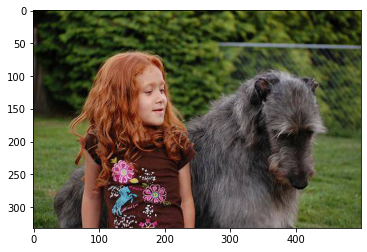

In [131]:
## loc gets rows (or columns) with particular labels from the index.
# Example: len(df_labels.loc[df_labels.breed == 'scottish_deerhound'])
# iloc gets rows (or columns) at particular positions in the index (so it only takes integers).
# Example: .iloc[0,0] == is the first entry
# Source explanation : https://stackoverflow.com/questions/31593201/how-are-iloc-and-loc-different
scottish_deerhound_id = df_labels.loc[df_labels.breed == 'scottish_deerhound'].iloc[0,0]
image = load_img('input/data/train/' + scottish_deerhound_id + '.jpg')
plt.imshow(image)

# uncomment this to understand the workings from loc and iloc
# print(df_labels.loc[df_labels.breed == 'scottish_deerhound'].iloc[2,0])
# (df_labels.loc[df_labels.breed == 'scottish_deerhound'])

What are the most rare breeds in the dataset?

In [132]:
print('Most rarest breed in the dataset:', gr_labels.tail(1))
gr_labels.tail()

Most rarest breed in the dataset:             count  filename
breed                      
eskimo_dog     66        66


,count,filename
breed,,
golden_retriever,67,67
brabancon_griffon,67,67
komondor,67,67
briard,66,66
eskimo_dog,66,66


How does the Eskimo dog look like?

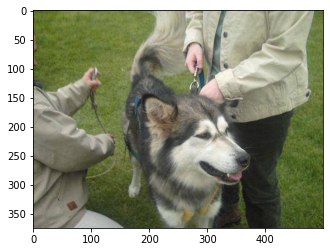

In [133]:
eskimo_dog_id = df_labels.loc[df_labels.breed == 'eskimo_dog'].iloc[2,0]
image = load_img('input/data/train/' + eskimo_dog_id + '.jpg')
plt.imshow(image)

In [134]:
df_train2, df_validate = train_test_split(df_train, test_size=0.20, random_state=42)
# df_train2 = df_train2.reset_index(drop=True)
# df_validate = df_validate.reset_index(drop=True)

In [135]:
df_train2.shape

(8177, 3)

In [136]:
df_validate.shape

(2045, 3)

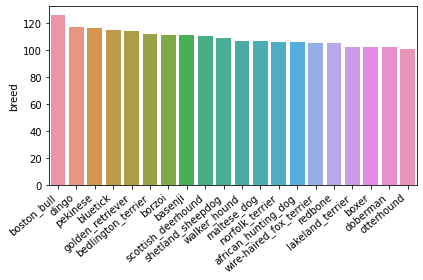

In [137]:
# plt.figure(figsize=(20,20)) #uncomment for big fig size, to read labels
ax = sns.barplot(x=df_labels.breed.unique()[:20], y=df_labels.breed.value_counts()[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()
plt.show()
# df_labels.breed.value_counts()

In [169]:
total_train = df_train2.shape[0]
total_validate = df_validate.shape[0]
print(total_train)
print(total_validate)

8177
2045


# Train Generator

In [210]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    df_train2,
    'input/data/train/',
    x_col='filename',
    y_col='breed',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8177 validated image filenames belonging to 120 classes.


# Visualise augmented training data

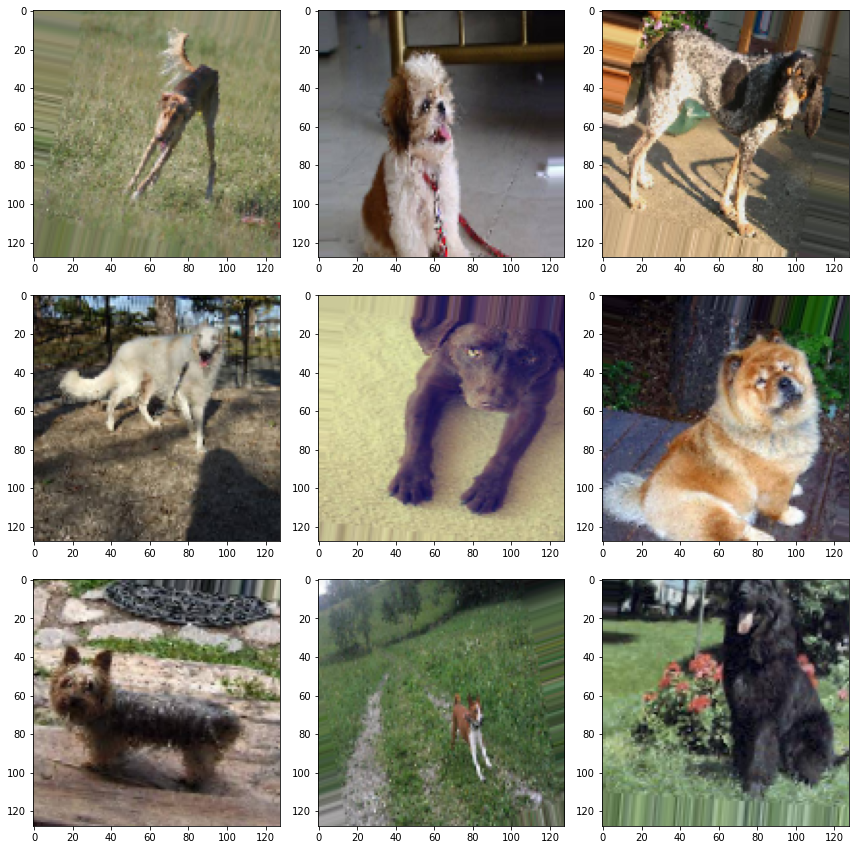

In [218]:
plt.figure(figsize=(8, 8))
for image in range(0, 9):
    plt.subplot(3, 3, image+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [190]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_validate,
    'input/data/train/',
    x_col='filename',
    y_col='breed',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2045 validated image filenames belonging to 120 classes.


Visualise the train generator

Found 1 validated image filenames belonging to 1 classes.


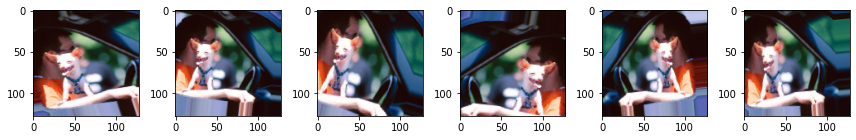

In [191]:
# show validation examples of one image batch
example_df = df_train2.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    'input/data/train/',
    x_col='filename',
    y_col='breed',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Great model

Also creating the callback mechanism and the early stopping when model reaches a equilibrium 

In [212]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.0001
)

callbacks = [earlystop, learning_rate_reduction]

In [213]:
model = Sequential()
model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(120,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit model

In [ ]:
model_history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS, 
    validation_data=validation_generator, 
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

In [205]:
## When this is done. It is time to evaluate the model.

# Load model if one exist on OS

In [ ]:
# Load model from disk
model = tf.keras.models.load_model('saved-models/dogs_breeds-model')

# Load history from JSON file
history_dict = json.load(open('saved-models/history/dogs_breeds-model-history.json', 'r'))

# Save model if you want to save one :)

In [ ]:
# Saving only the weights of the model
# model.save_weights("model.h5")

# Saving complete model
model.save('saved-models/dogs_breeds-model')

# Save history to json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(str(history_dict), open('saved-models/history/dogvscat-model-history.json', 'w'))

# Visualize Training

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//BATCH_SIZE, workers=12)
print('Test: accuracy = %f ; loss = %f ' % (accuracy, loss))

def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history[acc])+1),model_history[acc])
    axs[0].plot(range(1,len(model_history[val_acc])+1),model_history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history[acc])+1),len(model_history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs[1].plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(model_history)

# Make prediction of fitted model